### 2nd Order Linear PDE Scheme Implementation

In [2]:
import numpy as np
import sympy as sp
from matplotlib import pyplot
import ipywidgets
%matplotlib inline

In [3]:
pyplot.rc('font', family='serif', size=16)

In [4]:
def rho_redlight(x, rho_max):
    rho = np.full_like(x, rho_max)
    # rho = rho_max * np.ones_like(x) ... similar to above line
    mask = np.where(x < 3.)
    rho[mask] /= 2
    # rho[mask] = rho_max / 2 ... similar to line above (somehow)
    return rho

In [36]:
# params set
nx = 81
L = 4.
dx = L / (nx - 1)          # grid spacing
x = np.linspace(0., L, num=nx)
dt = 1 * dt / u_max

rho_max = 10.
u_max = 1.

rho_0 = rho_redlight(x, rho_max)

In [37]:
def plot(n, x, rho_hist, ):
    pyplot.figure()
    pyplot.grid()
    pyplot.title('Time step: {}'.format(n))
    pyplot.xlabel('Road [km]')
    pyplot.ylabel('Traffic Density [cars/hr]')
    pyplot.plot(x, rho_hist[n], color='C6', linewidth = 3)
    pyplot.xlim(x[0], x[-1])
    pyplot.ylim(4., 11.)
    pyplot.show()

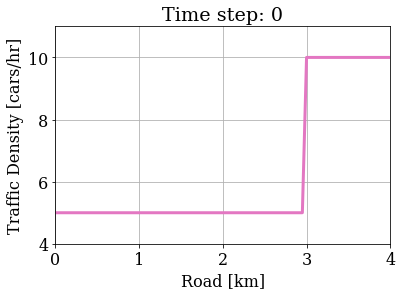

In [38]:
plot(0, x, [rho_0])

In [39]:
def traffic_speed(rho, u_max, rho_max):
    return u_max * (1 - rho / rho_max)

def traffic_flux(rho, u_max, rho_max):
    return rho * traffic_speed(rho, u_max, rho_max)

In [40]:
def interactive_plot(x, rho_hist):
    nt = len(rho_hist) - 1
    nt_slider = ipywidgets.IntSlider(value=0., min=0.,max=nt, step=1,
                                     description = 'Time Step')
    w = ipywidgets.interactive(plot, n=nt_slider,
                               x=ipywidgets.fixed(x),
                               rho_hist = ipywidgets.fixed(rho_hist))
    return w

In [41]:
interactive_plot(x, [rho_0])

interactive(children=(IntSlider(value=0, description='Time Step', max=0), Output()), _dom_classes=('widget-int…

In [62]:
def lax_fried(rho_0, nt, dt, dx, u_max, rho_max):
    rho_hist = [rho_0.copy()]
    rho = rho_0.copy()
    nx = len(rho_0)
    for n in range(nt):
        rhon = rho.copy()
        F = traffic_flux(rhon, u_max, rho_max)
        for i in range(1, nx-1):
            rho[i] = (0.5 * (rhon[i-1] + rhon[i+1]) - dt * (F[i+1] - F[i-1]) / (2*dx))   
            
        rho_hist.append(rho.copy())
    """
    for n in range(nt):
    rhon = np.copy(rho)
        flx = traffic_flux(rho, u_max, rho_max)
        rho[1:-1] = (0.5 * (rhon[:-2] + rhon[2:]) - dt / (2 * dx) * (flx[2:] - flx[:-2]))
        rho_hist.append(rho.copy())
        
    # Boundary conditions are skipped since they remain the same from rho0 to rho.copy
    """
    
    return rho_hist

In [63]:
nt = 40
sigma = 1. 
dt = sigma * dx / u_max

rho_hist = lax_fried(rho_0, nt, dt, dx, u_max, rho_max)

interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time Step', max=40), Output()), _dom_classes=('widget-in…

In [69]:
sigma = 0.5
dt = sigma * dx / u_max
nt = 150

rho_hist = lax_fried(rho_0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time Step', max=150), Output()), _dom_classes=('widget-i…

### Lax Friedrich introduces diffusive errors in solution

## Lax - Wendroff Scheme Below

In [75]:
def tj(rho, u_max, rho_max):
    J = u_max * (1. - 2. * rho / rho_max)
    return J

def lax_wend(rho_0, nt, dt, dx, u_max, rho_max):
    rho_hist = [rho_0.copy()]
    rho = rho_0.copy()
    for n in range(nt):
        F = traffic_flux(rho, u_max, rho_max)
        J = tj(rho, u_max, rho_max)
        rho[1:-1] = (rho[1:-1] - dt / (2. * dx) * (F[2:] - F[:-2]) + dt**2 / (4. * dx**2) *
                    ((J[1:-1] + J[2:]) * (F[2:] - F[1:-1]) - (J[:-2] + J[1:-1]) * (F[1:-1] - F[:-2])))
        rho_hist.append(rho.copy())
    return rho_hist

In [76]:
sigma = 1.
dt = sigma * dx / u_max
nt = 40

rho_hist = lax_wend(rho_0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time Step', max=40), Output()), _dom_classes=('widget-in…

## Lax-Wend introduces dispersion errors ( see above ) 

## Below is MacCormack Scheme

In [78]:
def mac(rho_0, nt, dt, dx, u_max, rho_max):
    rho_hist = [rho_0.copy()]
    rho = rho_0.copy()
    rho_n = rho.copy()
    for n in range(nt):
        F = traffic_flux(rho, u_max, rho_max)
        rho_n[1:-1] = (rho[1:-1] - dt/dx * (F[2:] - F[1:-1]))
        
        F = traffic_flux(rho_n, u_max, rho_max)
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_n[1:-1] - dt/dx * (F[1:-1] - F[:-2]))
        
        rho_hist.append(rho.copy())
    return rho_hist

In [79]:
sigma = 1.
dt = sigma * dx / u_max
nt = 40

rho_hist = mac(rho_0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time Step', max=40), Output()), _dom_classes=('widget-in…